## Error Analysis: what are our false predictions?

- how good is our model with staff pick
- how good is our model without the staff pick? (drop staff pick)
- how good is our model against the staff pick? (predict only staff picked rows)
- how good is out model on data the staff didn't pick

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import os

import src.visualization as vs
import src.process as process
import models.lib as modlib

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, KFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score, recall_score, precision_score
from sklearn.metrics import classification_report, roc_curve, confusion_matrix

# models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier

RSEED = 42

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
data = pd.read_csv('data/processed/kickstarter_clean.csv')


# Drop Staff Pick

data = data.drop(['staff_pick','usd_pledged','backers_count'], axis=1)
data.day_hour = data.day_hour.astype(str)
data.sample(5, random_state=RSEED)


y = data['state']
X = data.drop('state', axis=1)

X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X,y, stratify = y, test_size = 0.2, random_state = RSEED)

## Include Staff Pick

Categorical Features: ['country', 'staff_pick', 'usd_type', 'month', 'weekday', 'day_hour', 'category_name'] 
Numerical Features: ['converted_goal', 'len_blurb', 'len_name', 'launch_to_deadline', 'creation_to_launch']
scaledXGB - Time taken: 3.67 seconds


,FBeta,Accuracy,Recall,Precision
scaledXGB,0.841,0.815,0.819,0.847


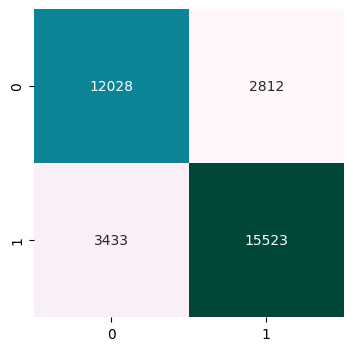

In [4]:
data = pd.read_csv('data/processed/kickstarter_clean.csv')

data = data.drop(['usd_pledged','backers_count'], axis=1)
data.day_hour = data.day_hour.astype(str)
data.sample(5, random_state=RSEED)

y = data['state']
X = data.drop('state', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2, random_state = RSEED)

target = 'state'
num_features, cat_features = process.num_cat_features(data, target=target)
models = {'XGB':  XGBClassifier(seed=RSEED)}

preprocessor = process.create_preprocessor(num_features, cat_features)
scaled_models = process.model_process_pipeline(models, preprocessor, prefix='scaled')

predictes_y_test_dict = process.model_test_predict(X_train, X_test, y_train, scaled_models)
display(vs.nice_scores(y_test, predictes_y_test_dict))

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, predictes_y_test_dict['scaledXGB']), fmt='g', annot=True, cmap='PuBuGn', cbar=False);

## Drop Staff Pick

Categorical Features: ['country', 'usd_type', 'month', 'weekday', 'day_hour', 'category_name'] 
Numerical Features: ['converted_goal', 'len_blurb', 'len_name', 'launch_to_deadline', 'creation_to_launch']
scaledXGB - Time taken: 3.60 seconds


,FBeta,Accuracy,Recall,Precision
scaledXGB,0.815,0.792,0.812,0.816


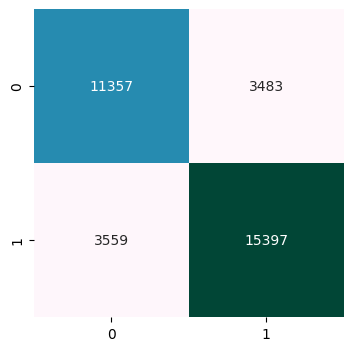

In [5]:
data = pd.read_csv('data/processed/kickstarter_clean.csv')


# Drop Staff Pick

data = data.drop(['staff_pick','usd_pledged','backers_count'], axis=1)
data.day_hour = data.day_hour.astype(str)
data.sample(5, random_state=RSEED)


y = data['state']
X = data.drop('state', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2, random_state = RSEED)


target = 'state'
num_features, cat_features = process.num_cat_features(data, target=target)
models = {'XGB':  XGBClassifier(seed=RSEED)}


preprocessor = process.create_preprocessor(num_features, cat_features)
scaled_models = process.model_process_pipeline(models, preprocessor, prefix='scaled')


predictes_y_test_dict = process.model_test_predict(X_train, X_test, y_train, scaled_models)
display(vs.nice_scores(y_test, predictes_y_test_dict))

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, predictes_y_test_dict['scaledXGB']), fmt='g', annot=True, cmap='PuBuGn', cbar=False);



,FBeta,Accuracy,Recall,Precision
scaledXGB,0.815,0.792,0.812,0.816


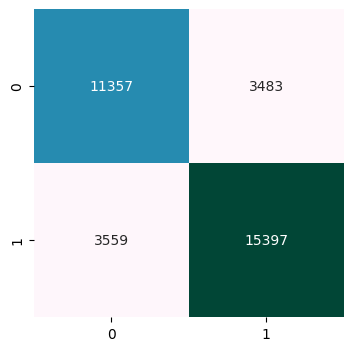

In [6]:
og_predictions = {}
scaled_models['scaledXGB'].fit(X_train, y_train)
og_predictions['scaledXGB'] = scaled_models['scaledXGB'].predict(X_test_og)

display(vs.nice_scores(y_test_og, og_predictions))

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test_og, og_predictions['scaledXGB']), fmt='g', annot=True, cmap='PuBuGn', cbar=False);

In [7]:
data_with_predictions = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True), pd.Series(predictes_y_test_dict['scaledXGB'], name='predictions').reset_index(drop=True)], axis=1)

prediction_errors = data_with_predictions.query('state != predictions')
prediction_errors.to_csv(os.path.join('data/processed/', 'kickstarter_errors.csv'), index=False)
prediction_errors

,country,usd_type,converted_goal,len_blurb,len_name,launch_to_deadline,creation_to_launch,month,weekday,day_hour,category_name,state,predictions
0,US,international,21000.00,22.0,8,3715200,30762053,June,Tuesday,21,Footwear,1,0
1,US,domestic,20000.00,22.0,5,3888000,2287597,March,Saturday,12,Kids,1,0
3,GB,international,15080.96,14.0,8,2592000,1193700,June,Friday,15,Puzzles,0,1
7,US,international,18000.00,27.0,7,2678400,2786382,March,Monday,5,Performance Art,0,1
17,US,international,12000.00,23.0,5,3456000,26960,August,Tuesday,6,World Music,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33773,US,domestic,2000.00,25.0,5,1468800,7348079,May,Sunday,1,Pop,0,1
33774,US,domestic,10.00,24.0,4,2592000,93731,July,Wednesday,5,Small Batch,1,0
33776,FR,international,16770.55,19.0,7,2592000,809588,June,Wednesday,17,Hardware,0,1
33777,US,international,2000.00,20.0,8,3884400,665041,February,Tuesday,10,Comedy,0,1


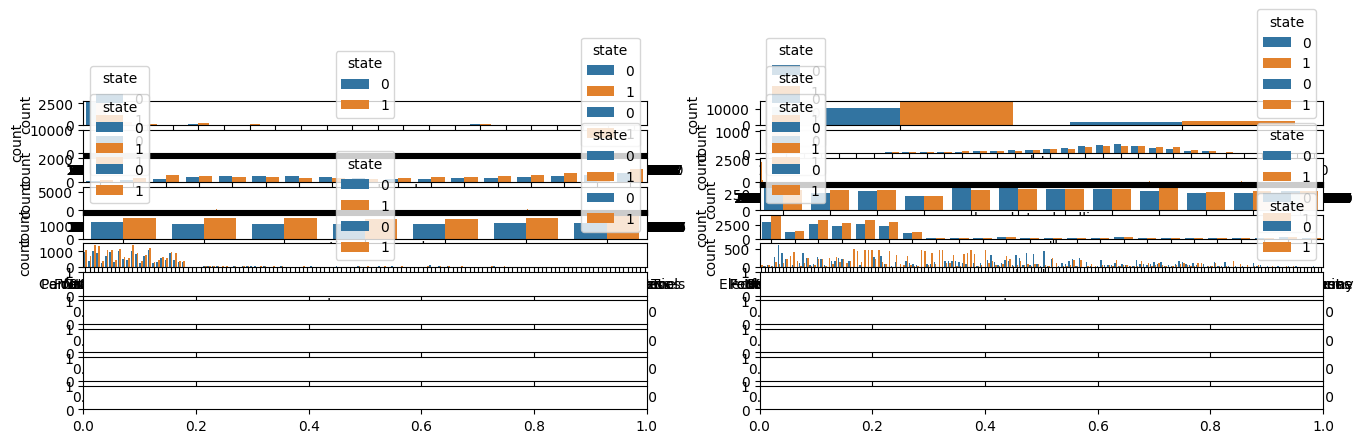

In [8]:
j=len(X_test.columns)
fig, axs = plt.subplots(ncols=2,nrows=j,figsize=(16, 4)) 
for k, column in enumerate(X_test.columns):
    

    sns.countplot(data=prediction_errors, x=column, ax=axs.flat[k], hue='state')
    sns.countplot(data=X_test, x=column, ax=axs.flat[k+1], hue=y_test)

In [9]:
len(X_test.columns)

11

In [10]:
vs.nice_summary(prediction_errors)

,Columns,Dtype,nunique,Non-Null Count,Missing,Missing %,Zero Count,mean,std,min,25%,50%,75%,max
0,country,object,22,7042,-,-,0,-,-,-,-,-,-,-
1,usd_type,object,2,7042,-,-,0,-,-,-,-,-,-,-
2,converted_goal,float64,2427,7042,-,-,0,11304.49,28722.49,1.0,1500.0,4500.0,10058.94,1000000.0
3,len_blurb,float64,32,7042,-,-,0,18.98,4.89,1.0,16.0,20.0,22.0,35.0
4,len_name,int64,17,7042,-,-,0,5.86,2.65,1.0,4.0,6.0,8.0,21.0
5,launch_to_deadline,int64,2205,7042,-,-,0,2792436.58,989396.76,86400.0,2588400.0,2592000.0,2930207.25,7858800.0
6,creation_to_launch,int64,7032,7042,-,-,0,4173410.09,11059669.53,236.0,286734.5,1056173.0,3311927.75,224100016.0
7,month,object,12,7042,-,-,0,-,-,-,-,-,-,-
8,weekday,object,7,7042,-,-,0,-,-,-,-,-,-,-
9,day_hour,object,24,7042,-,-,0,-,-,-,-,-,-,-


## Only Staff Picked Data

Categorical Features: ['country', 'usd_type', 'month', 'weekday', 'day_hour', 'category_name'] 
Numerical Features: ['converted_goal', 'len_blurb', 'len_name', 'launch_to_deadline', 'creation_to_launch']
scaledXGB - Time taken: 0.50 seconds


,FBeta,Accuracy,Recall,Precision
scaledXGB,0.918,0.898,0.995,0.901


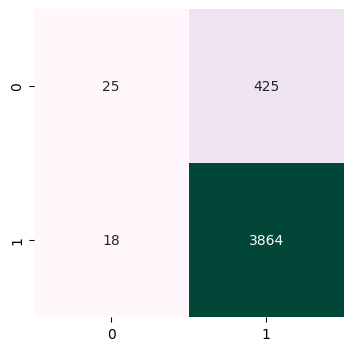

In [11]:
data = pd.read_csv('data/processed/kickstarter_clean.csv')


data = data.drop(['usd_pledged','backers_count'], axis=1)
data.day_hour = data.day_hour.astype(str)
data.sample(5, random_state=RSEED)


# Drop all Rows where staff pick == False, then drop staff pick

data = data.drop(data[data['staff_pick'] == False].index)
data = data.drop(['staff_pick'], axis=1)

y = data['state']
X = data.drop('state', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2, random_state = RSEED)


target = 'state'
num_features, cat_features = process.num_cat_features(data, target=target)
models = {'XGB':  XGBClassifier(seed=RSEED)}


preprocessor = process.create_preprocessor(num_features, cat_features)
scaled_models = process.model_process_pipeline(models, preprocessor, prefix='scaled')


predictes_y_test_dict = process.model_test_predict(X_train, X_test, y_train, scaled_models)
display(vs.nice_scores(y_test, predictes_y_test_dict))

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, predictes_y_test_dict['scaledXGB']), fmt='g', annot=True, cmap='PuBuGn', cbar=False);

In [16]:
from imblearn.over_sampling import SMOTE

# Choose an oversampling method
oversampler = SMOTE(random_state=RSEED)

# Apply oversampling to the training set
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

ValueError: could not convert string to float: 'US'

,FBeta,Accuracy,Recall,Precision
scaledXGB,0.636,0.599,0.996,0.584


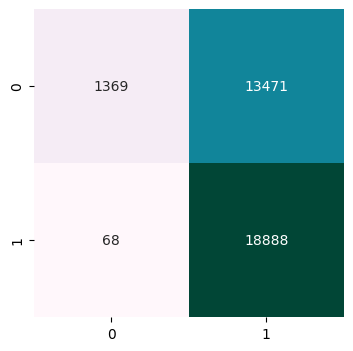

In [13]:
og_predictions = {}
scaled_models['scaledXGB'].fit(X_train, y_train)
og_predictions['scaledXGB'] = scaled_models['scaledXGB'].predict(X_test_og)

display(vs.nice_scores(y_test_og, og_predictions))

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test_og, og_predictions['scaledXGB']), fmt='g', annot=True, cmap='PuBuGn', cbar=False);

## Only non-Staff Picked Data

Categorical Features: ['country', 'usd_type', 'month', 'weekday', 'day_hour', 'category_name'] 
Numerical Features: ['converted_goal', 'len_blurb', 'len_name', 'launch_to_deadline', 'creation_to_launch']
scaledXGB - Time taken: 3.30 seconds


,FBeta,Accuracy,Recall,Precision
scaledXGB,0.82,0.804,0.772,0.832


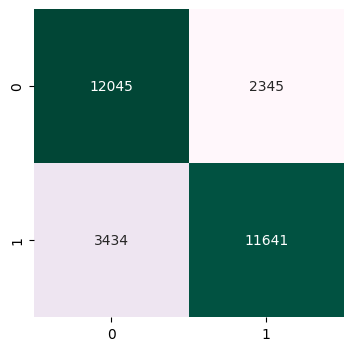

In [14]:
data = pd.read_csv('data/processed/kickstarter_clean.csv')


data = data.drop(['usd_pledged','backers_count'], axis=1)
data.day_hour = data.day_hour.astype(str)
data.sample(5, random_state=RSEED)


# Drop all Rows where staff pick == True

data = data.drop(data[data['staff_pick'] == True].index)
data = data.drop(['staff_pick'], axis=1)

y = data['state']
X = data.drop('state', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2, random_state = RSEED)


target = 'state'
num_features, cat_features = process.num_cat_features(data, target=target)
models = {'XGB':  XGBClassifier(seed=RSEED)}


preprocessor = process.create_preprocessor(num_features, cat_features)
scaled_models = process.model_process_pipeline(models, preprocessor, prefix='scaled')


predictes_y_test_dict = process.model_test_predict(X_train, X_test, y_train, scaled_models)
display(vs.nice_scores(y_test, predictes_y_test_dict))

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, predictes_y_test_dict['scaledXGB']), fmt='g', annot=True, cmap='PuBuGn', cbar=False);

,FBeta,Accuracy,Recall,Precision
scaledXGB,0.838,0.795,0.755,0.862


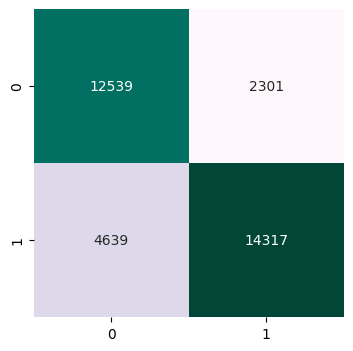

In [15]:
og_predictions = {}
scaled_models['scaledXGB'].fit(X_train, y_train)
og_predictions['scaledXGB'] = scaled_models['scaledXGB'].predict(X_test_og)

display(vs.nice_scores(y_test_og, og_predictions))

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test_og, og_predictions['scaledXGB']), fmt='g', annot=True, cmap='PuBuGn', cbar=False);

- make a table that only contains falsely predicted rows
- compare data distributions of falsely predicted vs entire data